In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Task Setup

## Reversal Learning Task
First, we set up a reversal learning task, modeled after the task used in Kahnt, Park et al. (2008).
There are three rules (or states) that determine the reward delivery:

1. 20:80 Choosing left (right) yield rewards in 20% (80%) of the time.
2. 80:20 Choosing left (right) yield rewards in 80% (20%) of the time.
3. 50:50 Choosing left (right) yield rewards in 50% (50%) of the time.

Subjects perform two blocks and 100 trials per block. 
As in the original the task rule changes (reverses) according to the following rules:

1. Reversals occur after 16 trials in the current rule or
2. Reversals occur after the subject chooses the better option in 70% of the cases and there were at least 10 trials with the current rule.

In [18]:
# %% 1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
# ------------------------------------------------------------------------
print("1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)")
print("---------------------------------------------------------------------")

# Set up the three different states (we changed the rewards from 1 to 0.5, for parameter values to better work with both tasks)
rv_states = {
    # 20:80
    0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
    # 80:20
    1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
    # 50:50
    2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [0.5, 0]},
}
rv_task_vars = rl.task.TaskVars(
    n_trials=100,
    n_blocks=2,
    n_options=2,
    states=rv_states,
    n_trials_reversal_min=10,    # minimum number of trials before reversal
    n_trials_reversal_max=16,    # maximum number of trials without reversal
    p_correct_reversal_min=0.7,  # minimum accuracy before reversal before `n_trials_reversal_max`
)

rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)
print(rv_task)

1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
---------------------------------------------------------------------
Reversal learning task with the states (rules):
  {0: {'p_r': [0.2, 0.8], 'a_correct': [1], 'rewards': [0.5, 0]}, 1: {'p_r': [0.8, 0.2], 'a_correct': [0], 'rewards': [0.5, 0]}, 2: {'p_r': [0.5, 0.5], 'a_correct': [0, 1], 'rewards': [0.5, 0]}}


# Agent

Next, we set up an dual learning rate agent to perform the task with known parameters $\alpha^{+}$, $\alpha^{-}$ and $\beta$:

In [19]:
# %% 2. Set up Dual-Learning-Rate Agent
# -------------------------------------
print("2. Set up Dual-Learning-Rate Agent")
print("----------------------------------")


# Use mean parameters from Lefebvre et al. (2017)
agent_vars = rl.agent.AgentVars(alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13))
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars, n_options=rv_task.task_vars.n_options, variant="delta"
)
print(agent)

2. Set up Dual-Learning-Rate Agent
----------------------------------
Dual learning rate agent (delta variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69


# Interaction

Now, we can let the agent perform the task:

In [20]:
np.random.seed(1)
df = rl.interaction.agent_task_interaction(rv_task, agent)
df.head(10)

,trial,block,state,p_r_0,ev_0,p_r_1,ev_1,r,a,s,corr,p_a_0,Q_0,p_a_1,Q_1,ll
0,0.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.799731,0.180000,0.200269,0.0,-0.223480
2,2.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.906427,0.295200,0.093573,0.0,-0.098245
3,3.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.944690,0.368928,0.055310,0.0,-0.056898
4,4.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.960867,0.416114,0.039133,0.0,-0.039919
5,5.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.968725,0.446313,0.031275,0.0,-0.031774
6,6.0,0.0,1.0,0.8,0.4,0.2,0.1,0.0,0.0,0.0,1.0,0.972929,0.465640,0.027071,0.0,-0.027444
7,7.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.942342,0.363199,0.057658,0.0,-0.059387
8,8.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.959793,0.412448,0.040207,0.0,-0.041038
9,9.0,0.0,1.0,0.8,0.4,0.2,0.1,0.5,0.0,0.0,1.0,0.968174,0.443966,0.031826,0.0,-0.032344


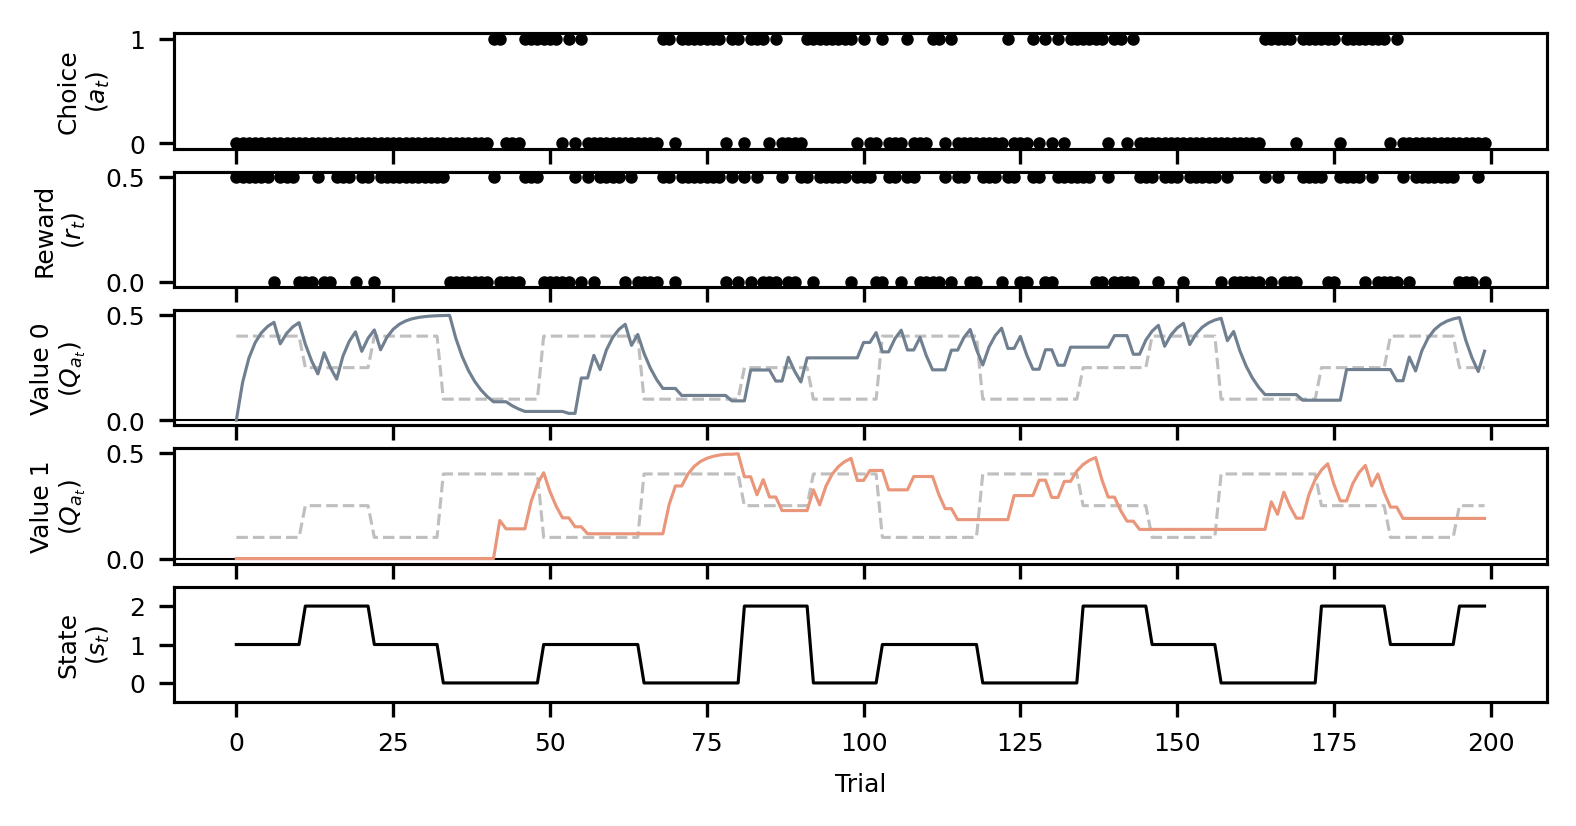

In [21]:
rl.plots.plot_data(data=df);

# Estimation

Given the behavioural data, we can try to estimate the agent's parameters:

In [22]:
# Define parameters to estimate
parameters = ['alpha_pos', 'alpha_neg', 'beta']

# Set boundaries (used to initialize and constrain estimation)
bounds = {'alpha_pos': (0, 1), 'alpha_neg': (0, 1), 'beta': (0, 20)}

# Initialize estimation variables and estimation instance
# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(rv_task_vars,
                                        agent_class=rl.agent.DualLearningRateAgent,
                                        parameters=parameters,
                                        bounds=bounds,
                                        n_sp=10)
est = rl.estimation.Estimation(est_vars)

In [23]:
# We can compute the neggative log-likelihood (nll) of the data, given the true parameters, as a reference:
est.nll(x=[agent.agent_vars.alpha_pos,
           agent.agent_vars.alpha_neg,
           agent.agent_vars.beta],
        data=df,
        agent_vars=agent_vars)

86.5136071081598

In [24]:
# Now we can estimate the maximum likelihood parameters
result = est.estimate(data=df, seed=1)
result

(76.97311351828284,
 169.8411791362098,
 [0.25852646068283297, 0.2307438133888705, 11.442268448742412])

The estimated parameters are close to, but not identical to the true parameters. We can simulate data from an agent using the estimated parameters and compare the prediction to the original data on different measures:

In [25]:
est_agent_vars = rl.agent.AgentVars(alpha_pos=result[2][0],
                                    alpha_neg=result[2][1],
                                    beta=result[2][2])
est_agent = rl.agent.DualLearningRateAgent(agent_vars=est_agent_vars,
                                           n_options=rv_task.task_vars.n_options)
est_agent

Dual learning rate agent (delta variant) with
  alpha_pos = 0.26
  alpha_neg = 0.23
  beta = 11.44

In [26]:
np.random.seed(1)
pred = rl.interaction.agent_task_interaction(task=rv_task, agent=est_agent)
pred.head()

,trial,block,state,p_r_0,ev_0,p_r_1,ev_1,r,a,s,corr,p_a_0,Q_0,p_a_1,Q_1,ll
0,0.0,0.0,2.0,0.5,0.25,0.5,0.25,0.0,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,2.0,0.5,0.25,0.5,0.25,0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
2,2.0,0.0,2.0,0.5,0.25,0.5,0.25,0.5,0.0,0.0,1.0,0.814431,0.129263,0.185569,0.0,-0.205265
3,3.0,0.0,2.0,0.5,0.25,0.5,0.25,0.5,0.0,0.0,1.0,0.929285,0.225108,0.070715,0.0,-0.073340
4,4.0,0.0,2.0,0.5,0.25,0.5,0.25,0.0,0.0,0.0,1.0,0.967356,0.296175,0.032644,0.0,-0.033188


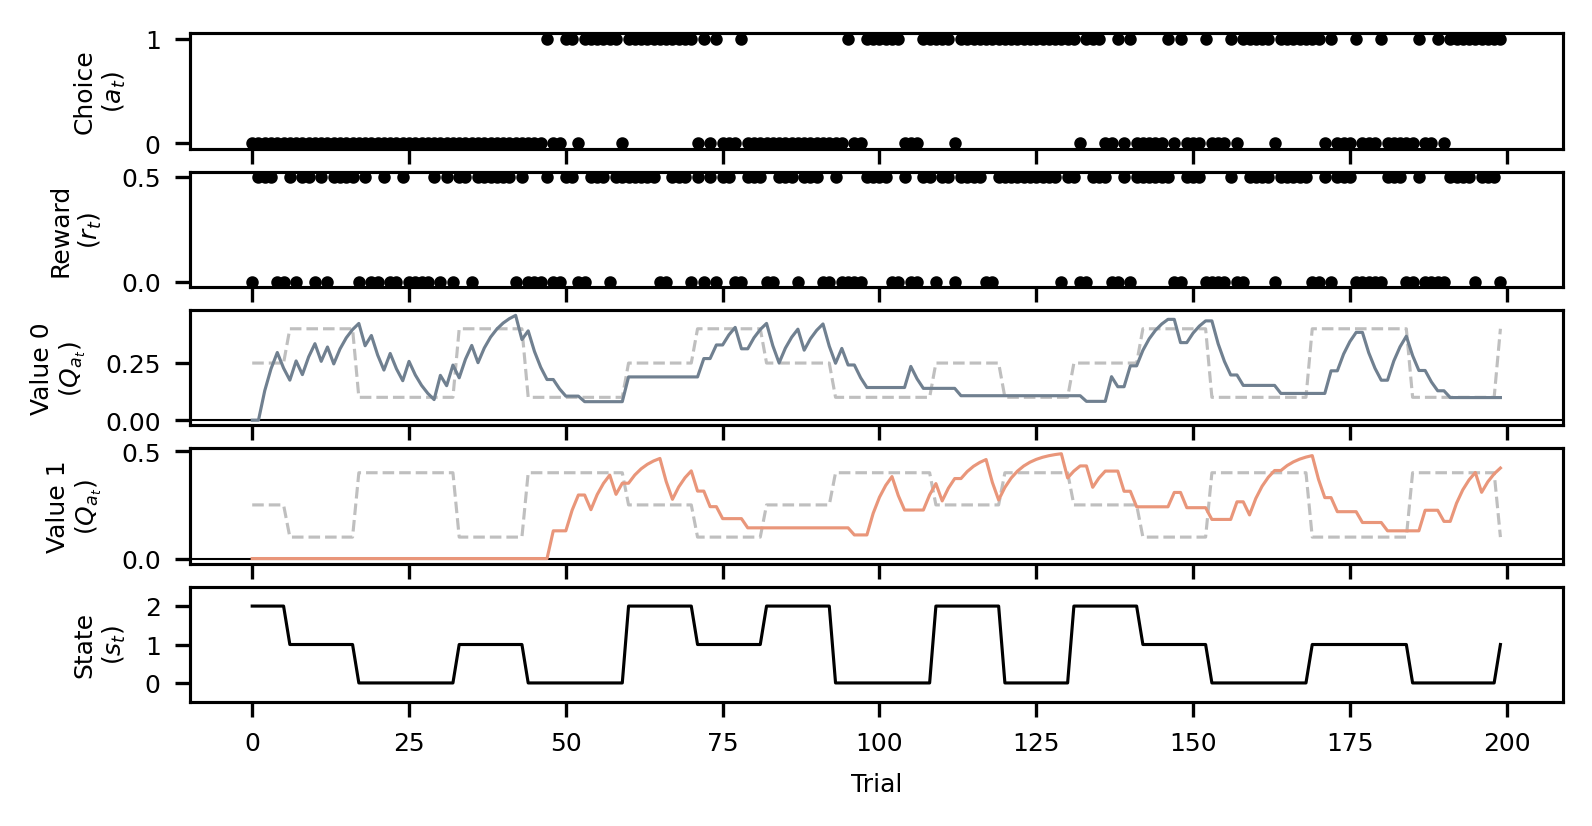

In [27]:
rl.plots.plot_data(pred);

TODO: What measures to look at here?

# Recovery

## Reversal-learning task

In [28]:
rv_task

Reversal learning task with the states (rules):
  {0: {'p_r': [0.2, 0.8], 'a_correct': [1], 'rewards': [0.5, 0]}, 1: {'p_r': [0.8, 0.2], 'a_correct': [0], 'rewards': [0.5, 0]}, 2: {'p_r': [0.5, 0.5], 'a_correct': [0, 1], 'rewards': [0.5, 0]}}

In [ ]:
# Set up agent
agent_vars = rl.agent.AgentVars(alpha_pos=np.nan,
                                alpha_neg=np.nan,
                                beta=np.nan)
agent = rl.agent.DualLearningRateAgent(agent_vars=agent_vars,
                                       n_options=rv_task.task_vars.n_options,
                                       n_states=1)
agent

In [30]:
# Set up parameter ranges
alpha_pos_values = {
    "variable": np.linspace(0, 1.0, 10),
    "low": 0.1,
    "medium": 0.3,
    "high": 0.6,
}
alpha_neg_values = {
    "variable": np.linspace(0, 1.0, 10),
    "low": 0.1,
    "medium": 0.3,
    "high": 0.6,
}
beta_values = {"variable": np.linspace(1, 10, 10), "low": 3, "medium": 5, "high": 10}
parameter_values = {
    "alpha_pos": alpha_pos_values,
    "alpha_neg": alpha_neg_values,
    "beta": beta_values,
}

In [32]:
# Set up estimation
est_vars = rl.estimation.EstimationVars(task_vars=rv_task_vars,
                                        agent_class=rl.agent.DualLearningRateAgent,
                                        parameters=['alpha_pos', 'alpha_neg', 'beta'],
                                        bounds={'alpha_pos': (0, 1),
                                                'alpha_neg': (0, 1),
                                                'beta': (0, 20)},
                                        n_sp=1)
est = rl.estimation.Estimation(est_vars=est_vars)

In [33]:
recovery_results = rl.recovery.run_recovery(rv_task, agent, est, parameter_values)

In [34]:
recovery_results.head()

,variable,alpha_pos,alpha_neg,beta,alpha_pos_hat,alpha_neg_hat,beta_hat,n_trials,n_blocks,n_sp,alpha_pos_level,alpha_neg_level,beta_level
0,alpha_pos,0.000000,0.1,3.0,0.000000,0.000000,0.000000,100,2,1,variable,low,low
1,alpha_pos,0.111111,0.1,3.0,0.014324,0.752117,20.000000,100,2,1,variable,low,low
2,alpha_pos,0.222222,0.1,3.0,0.193610,0.101728,3.321175,100,2,1,variable,low,low
3,alpha_pos,0.333333,0.1,3.0,0.000000,0.000000,0.000000,100,2,1,variable,low,low
4,alpha_pos,0.444444,0.1,3.0,1.000000,0.960699,1.131123,100,2,1,variable,low,low


In [35]:
recovery_results.to_csv('recovery-results.csv')

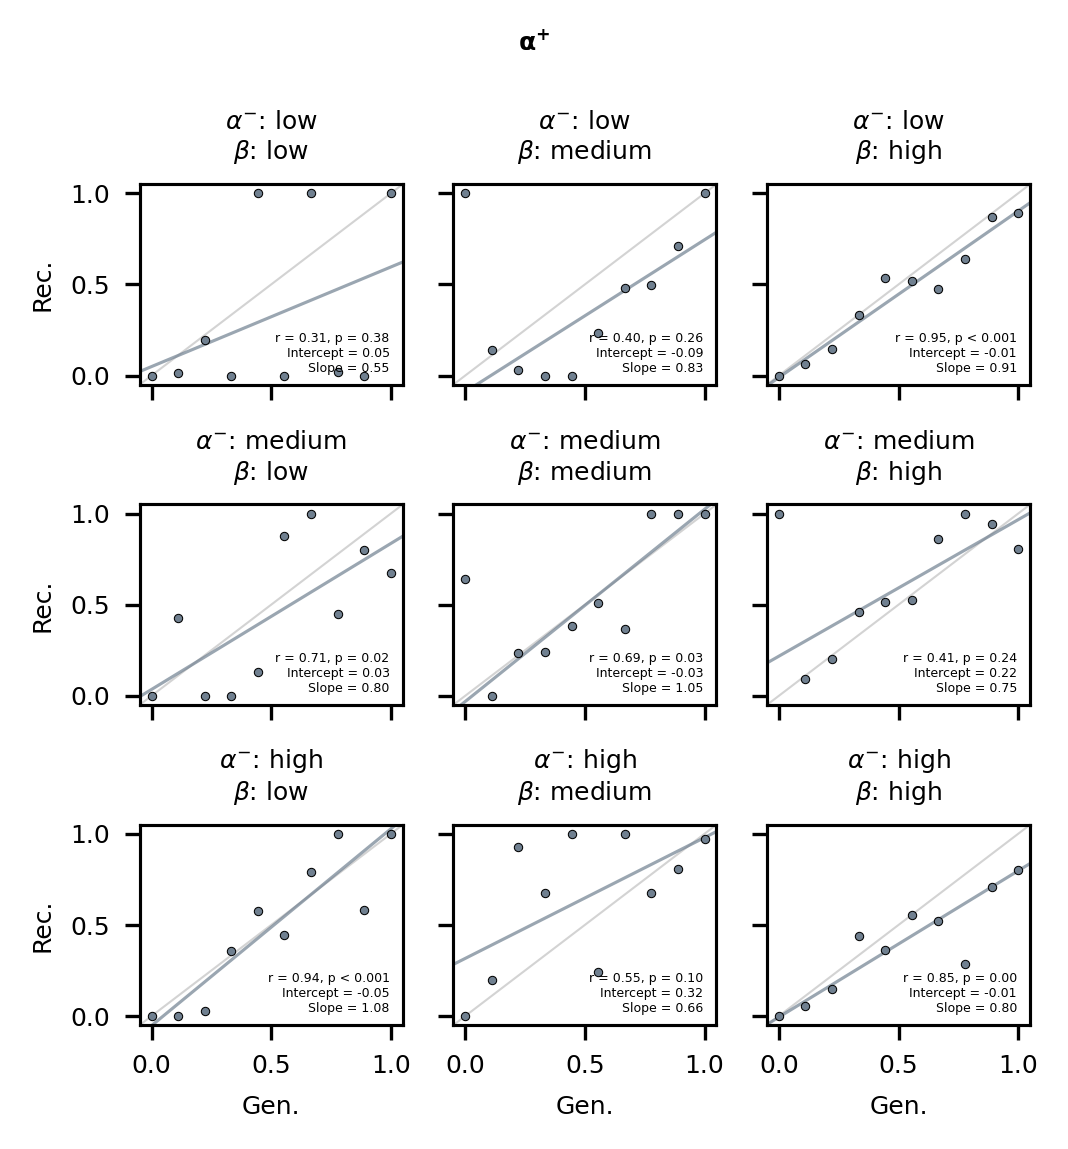

In [39]:
rl.plots.plot_recovery_results(recovery_results,
                      'alpha_pos',
                      ticks=np.linspace(0, 1, 3),
                      limits=[-0.05, 1.05]);

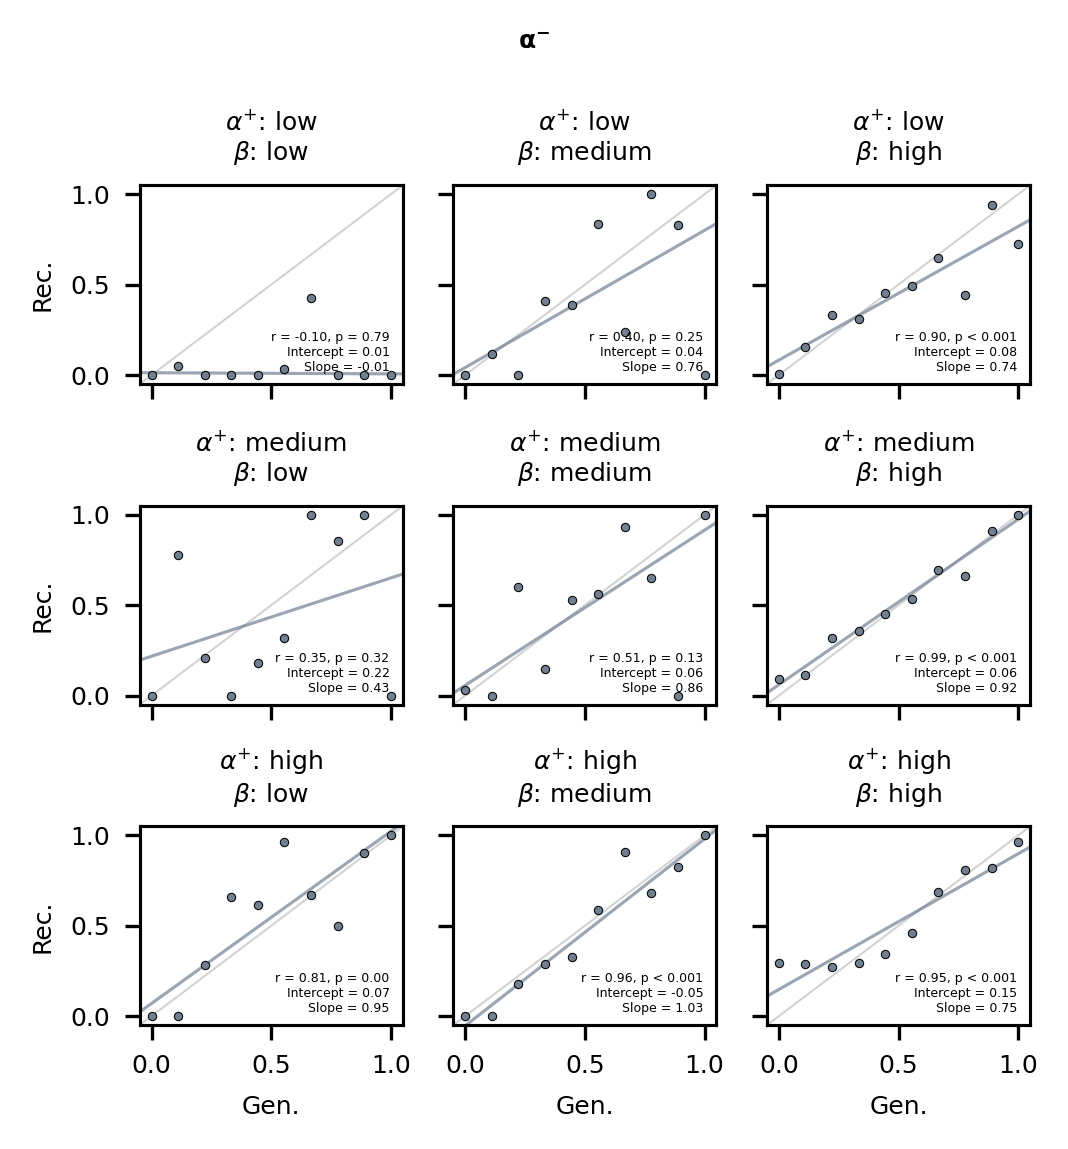

In [40]:
rl.plots.plot_recovery_results(recovery_results,
                      'alpha_neg',
                      ticks=np.linspace(0, 1, 3),
                      limits=[-0.05, 1.05]);

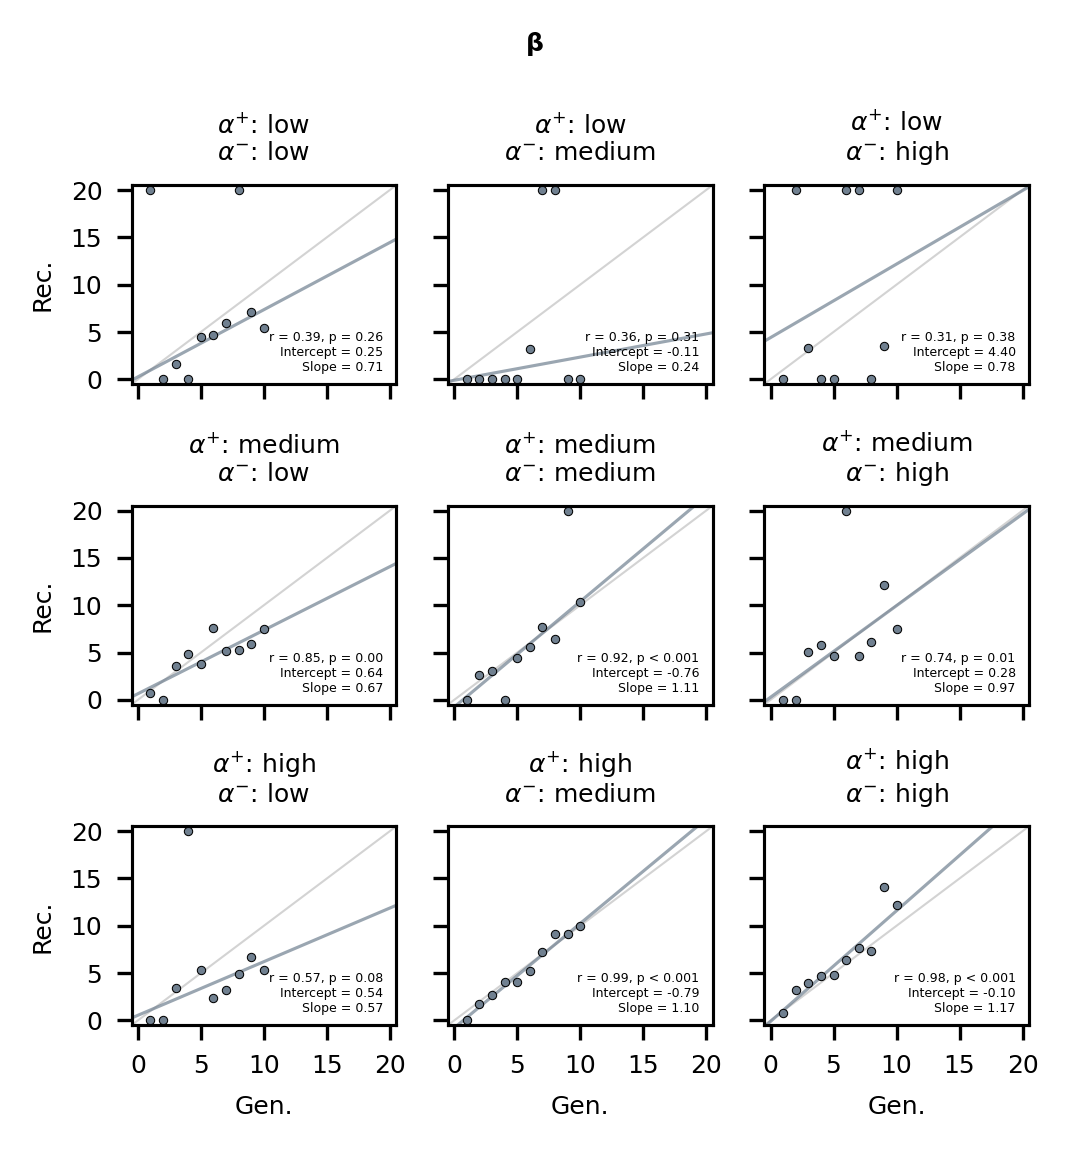

In [41]:
rl.plots.plot_recovery_results(recovery_results,
                      'beta',
                      ticks=np.linspace(0, 20, 5),
                      limits=[-0.5, 20.5]);